# 필요 라이브러리 임포트 

In [1]:
#file 
import os

# data
import pandas as pd
import geopandas as gpd
from pandas import Series, DataFrame
import numpy as np
import os 
import warnings
warnings.filterwarnings("ignore") 


# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline
from matplotlib import rc
rc('font',family='AppleGothic')
 
if os.name == 'nt':
    font_family = "Malgun Gothic"
else:
    font_family = "AppleGothic"
    
sns.set(font=font_family, rc = {"axes.unicode_minus" : False}) #-값이 깨지는 문제 해결을 위해 파라미터값 설정   

# preprocessing|
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth


# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics.cluster import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import *

## 파일 경로 설정

In [ ]:
# 새로운 작업 디렉토리 경로
new_working_directory = "C:/Users/User/도서관데이터공모전/raw data"

# 작업 디렉토리 변경
os.chdir(new_working_directory)

# 데이터 전처리

### 법정동 행정구역도

In [ ]:
shp_file_path = 'LSMD_ADM_SECT_UMD_11.shp'

gdf = gpd.read_file(shp_file_path,encoding = "cp949")
#좌표계
gdf = gdf.to_crs("epsg:4326")

# 데이터 확인
gdf = gdf[['EMD_CD','EMD_NM', 'geometry']]
gdf

In [ ]:
# 인덱스 열로 있는 'EMD_NM'을 열로 변환
gdf.reset_index(inplace=True)
gdf.loc[gdf['EMD_CD'] == '11380109', 'EMD_NM'] = '은평구_신사동'
gdf.loc[gdf['EMD_CD'] == '11680107', 'EMD_NM'] = '강남구_신사동'
gdf.loc[gdf['EMD_CD'] == '11440117', 'EMD_NM'] = '마포구_신정동'
gdf.loc[gdf['EMD_CD'] == '11470101', 'EMD_NM'] = '양천구_신정동'

### 버스정류장

In [ ]:
bus = pd.read_csv('버스정류장데이터.csv')
bus = bus[bus["도시명"] == "서울특별시"]

In [ ]:
bus = gpd.GeoDataFrame(bus,
                geometry=gpd.points_from_xy(bus.경도, bus.위도),
                             crs='epsg:4326')

bus = gpd.sjoin(bus, gdf, how='left', op="within")

In [ ]:
# '정류장ID'와 'EMD_NM' 열이 같은 경우 중복 행 제거
bus = bus.drop_duplicates(subset=['정류장번호', 'EMD_NM'], keep='first')

In [ ]:
bus_counts = bus['EMD_NM'].value_counts()

# 개수 정보를 데이터프레임으로 변환
bus_counts = pd.DataFrame({'법정동': bus_counts.index, '버스정류장': bus_counts.values})

In [ ]:
# bus_counts.to_csv("버스정류장개수.csv",encoding = 'cp949')

### 지하철역

In [ ]:
subway = pd.read_csv("서울시 역사마스터 정보.csv",encoding='cp949')
subway

In [ ]:
subway= gpd.GeoDataFrame(subway,
                geometry=gpd.points_from_xy(subway.경도, subway.위도),
                             crs='epsg:4326')
subway = gpd.sjoin(subway, gdf, how='left', op="within")

In [ ]:
# 'END_NM' 열이 결측치인 행 제거
subway = subway.dropna(subset=['EMD_NM'])

In [ ]:
# '정류장ID'와 'EMD_NM' 열이 같은 경우 중복 행 제거
subway = subway.drop_duplicates(subset=['역사_ID'], keep='first')

# 중복 행 제거된 결과 출력
subway

In [ ]:
subway_counts = subway['EMD_NM'].value_counts()

# 개수 정보를 데이터프레임으로 변환
subway_counts = pd.DataFrame({'법정동': subway_counts.index, '지하철역': subway_counts.values})

In [ ]:
subway_counts.to_csv("지하철역개수.csv",encoding = 'cp949')

### 노인주거시설

In [ ]:
shp_file_path_2 = '노인주거복지시설.shp'

df = gpd.read_file(shp_file_path_2)[["field1","geometry"]]
df

# 새로운 열에 위도와 경도 추가
df["위도"] = df["geometry"].y
df["경도"] = df["geometry"].x

gdf_o = gpd.GeoDataFrame(df,
                geometry=gpd.points_from_xy(df.경도, df.위도),
                             crs='epsg:4326')

gdf_o  = gpd.sjoin(gdf_o, gdf, how='left', op="within")

In [ ]:
# '정류장ID'와 'EMD_NM' 열이 같은 경우 중복 행 제거
gdf_o = gdf_o .drop_duplicates(subset=['field1'], keep='first')

In [ ]:
gdf_o = gdf_o[gdf_o["EMD_NM"].notna()]
gdf_o

In [ ]:
gdf_o_count = gdf_o['EMD_NM'].value_counts()
# gdf_o_count.rename(columns={"EMD_NM": "법정동"}, inplace=True)
gdf_o_count = pd.DataFrame({'법정동': gdf_o_count.index, '노인주거시설': gdf_o_count.values})

In [ ]:
# gdf_o_count.to_csv('노인주거시설개수.csv',encoding='cp949')

### 노인여가시설

In [ ]:
leisure = pd.read_csv('노인여가시설.csv')

In [ ]:
# 조건 1: 'SIGNGU_NM' 열이 '강남구'이고 'LEGALDONG_NM' 열이 '신사동'인 행
condition_1 = (leisure['SIGNGU_NM'] == '강남구') & (leisure['LEGALDONG_NM'] == '신사동')

# 조건 2: 'SIGNGU_NM' 열이 '양천구'이고 'LEGALDONG_NM' 열이 '신정동'인 행
condition_2 = (leisure['SIGNGU_NM'] == '양천구') & (leisure['LEGALDONG_NM'] == '신정동')

# 조건 3: 'SIGNGU_NM' 열이 '은평구'이고 'LEGALDONG_NM' 열이 '신당동'인 행
condition_3 = (leisure['SIGNGU_NM'] == '은평구') & (leisure['LEGALDONG_NM'] == '신사동')

# 각 조건을 만족하는 행의 'LEGALDONG_NM' 값을 변경
leisure.loc[condition_1, 'LEGALDONG_NM'] = '강남구_신사동'
leisure.loc[condition_2, 'LEGALDONG_NM'] = '양천구_신정동'
leisure.loc[condition_3, 'LEGALDONG_NM'] = '은평구_신사동'

# 변경된 결과 출력
leisure = leisure[leisure["CTPRVN_NM"] == "서울특별시"]

In [ ]:
leisure_counts = leisure['LEGALDONG_NM'].value_counts()

# 개수 정보를 데이터프레임으로 변환
leisure_counts = pd.DataFrame({'법정동': leisure_counts.index, '노인여가시설': leisure_counts.values})

In [ ]:
#leisure_counts.to_csv('노인여가시설개수.csv',encoding='cp949')

### 공공도서관

In [ ]:
shp_file_path_2 = '도서관데이터.shp'

library = gpd.read_file(shp_file_path_2)
#좌표계

# 'field4'와 'field5' 열 제거
library = library.drop(['field4', 'field5','_GC_TYPE'], axis=1)


# # 새로운 열에 위도와 경도 추가
library["위도"] = library["geometry"].y
library["경도"] = library["geometry"].x

library = gpd.GeoDataFrame(library,
                geometry=gpd.points_from_xy(library.경도, library.위도),
                             crs='epsg:4326')

gdf_library = gpd.sjoin(library, gdf, how='left', op="within")

In [ ]:
duplicate_rows_gdf_library = gdf_library[gdf_library.duplicated(subset='field1', keep=False)]

# 추출된 중복 행 출력
duplicate_rows_gdf_library

In [ ]:
gdf_library = gdf_library.drop_duplicates(subset=['field1'], keep='first')

In [ ]:
# 일부 열들 추출
selected_columns = ['field1', 'EMD_NM']  # 원하는 열 이름들로 수정

# 선택된 열들을 포함한 데이터프레임 생성
gdf_library = gdf_library[selected_columns]
gdf_library.rename(columns={'field1': '도서관명'}, inplace=True)
gdf_library.rename(columns={'EMD_NM': '법정동'}, inplace=True)

## 노인인구비율

In [ ]:
df = pd.read_csv("지역별(법정동) 성별 연령별 주민등록 인구수_20221231.csv",encoding="cp949")
df = df[df['시도명'] == "서울특별시"]

In [ ]:
selected_columns = df.columns[9:].to_list() + ['읍면동명'] + ['법정동코드'] +['계']
df = df[selected_columns]

In [ ]:
# '만 60세 남자'부터 '만 110세 이상 여자' 열의 위치를 가져옴
start_index_male = df.columns.get_loc('만60세남자')
end_index_male = df.columns.get_loc('만110세이상남자')
start_index_female = df.columns.get_loc('만60세여자')
end_index_female = df.columns.get_loc('만110세이상여자')

df['만 60세 이상 인구수'] = df.iloc[:, start_index_male:end_index_male+1].sum(axis=1) + df.iloc[:, start_index_female:end_index_female+1].sum(axis=1)

In [ ]:
df = df[['읍면동명','법정동코드', '만 60세 이상 인구수','계']]

In [ ]:
# 법정동 코드 열이 1138010900인 행의 '읍면동명' 열 값을 '은평구_신사동'으로 변경
df.loc[df['법정동코드'] == 1138010900, '읍면동명'] = '은평구_신사동'
df.loc[df['법정동코드'] == 1144011700, '읍면동명'] = '마포구_신정동'
df.loc[df['법정동코드'] == 1147010100, '읍면동명'] = '양천구_신정동'
df.loc[df['법정동코드'] == 1138010900, '읍면동명'] = '강남구_신사동'

In [ ]:
# '노인인구비율' 열 추가
df['노인인구비율'] = (df['만 60세 이상 인구수'] / df['계']) * 100
df = df[['읍면동명','노인인구비율']]

In [ ]:
# df.to_csv('노인인구비율.csv',encoding='cp949')

## 장애인노인보호구역

In [ ]:
df = pd.read_csv("전국노인장애인보호구역표준데이터.csv",encoding="cp949")

In [ ]:
df = df[df['장소유형코드'] == 1]
df_seoul = df[df["시도명"] == "서울특별시"]
df_seoul

In [ ]:
gdf_seoul = gpd.GeoDataFrame(df_seoul,
                geometry=gpd.points_from_xy(df_seoul.경도, df_seoul.위도),
                             crs='epsg:4326')

In [ ]:
gdf_seoul_2 = gpd.sjoin(gdf_seoul, gdf, how='left', op="within")

In [ ]:
gdf_seoul_2 = gdf_seoul_2.drop_duplicates(subset=['대상시설명'], keep='first')

In [ ]:
protectionarea_counts = gdf_seoul_2['EMD_NM'].value_counts()

# 개수 정보를 데이터프레임으로 변환
protectionarea_counts = pd.DataFrame({'법정동': protectionarea_counts.index, '노인보호구역': protectionarea_counts.values})

In [ ]:
# protectionarea_counts.to_csv('노인보호구역개수.csv',encoding='cp949')

## 데이터 통합

In [ ]:
bus = pd.read_csv("버스정류장_법정동별_개수.csv")
protection = pd.read_excel("노인보호구역_법정동별_개수.xlsx")
subway = pd.read_csv("지하철역_법정동별_개수.csv",encoding="cp949")
home = pd.read_csv("노인주거시설_법정동별_개수.csv")
leisure = pd.read_csv("노인여가시설_법정동별_개수.csv",encoding="cp949")
people = pd.read_csv("노인인구수_법정동별_개수.csv",encoding="cp949")

In [ ]:
leisure.rename(columns={'LEGALDONG_NM': '법정동'}, inplace=True)
leisure.rename(columns={'개수': '노인여가시설'}, inplace=True)
home.rename(columns={'EMD_NM': '법정동'}, inplace=True)
home.rename(columns={'Count': '노인주거시설'}, inplace=True)

In [ ]:
# 두 데이터프레임을 법정동을 기준으로 외부 조인 (모든 행 포함)
merged_df = pd.merge(leisure, home, on='법정동', how='outer')
# NaN 값을 0으로 채움
merged_df.fillna(0, inplace=True)

In [ ]:
# 개수 열을 합산하여 새로운 열 추가
merged_df['합계'] = merged_df['노인여가시설'] + merged_df['노인주거시설']

# 결과 출력
merged_df.rename(columns={'합계': '노인관련시설'}, inplace=True)
columns_to_extract = [merged_df.columns[0], merged_df.columns[3]]
merged_df = merged_df[columns_to_extract]

In [ ]:
# 열 이름 변경
bus.rename(columns={'개수': '버스정류장'}, inplace=True)
protection.rename(columns={'개수': '노인보호구역'}, inplace=True)
subway.rename(columns={'개수': '지하철역'}, inplace=True)
people.rename(columns={'EMD_NM': '법정동'}, inplace=True)

In [ ]:
# 모든 데이터프레임을 법정동을 기준으로 외부 조인
df = bus.merge(subway, on='법정동', how='outer') \
               .merge(merged_df, on='법정동', how='outer') \
               .merge(protection, on='법정동', how='outer') \
               .merge(people, on='법정동', how='outer') 
#                .merge(df_library, on='법정동', how='outer')

# NaN 값을 0으로 채움
df.fillna(0, inplace=True)

## 새로운 변수 생성

In [ ]:
df['지식정보취약계층_예산'] = df['노인_예산'] + df['다문화_예산'] +df['장애인_예산']
df['지식정보취약계층_이용자수'] =  df['지식정보취약계층 서비스 이용자수_노인'] + df['지식정보취약계층 서비스 이용자수_다문화'] +df['지식정보취약계층 서비스 이용자수_장애인']

# 랜덤포레스트로 변수중요도 추출

In [ ]:
df = pd.read_csv('면적대비 개수 노인인구비율수정 (1).csv')
index_column = '법정동'
df = df.set_index(index_column)

In [ ]:
# 한글 폰트 경로 설정
#font_path = 'C:/WINDOWS/Fonts/H2HDRM.TTF'

# 폰트 객체 생성
#fontprop = fm.FontProperties(fname=font_path)

# 데이터와 타겟 분리
X = df.drop('지식정보취약계층_이용자수', axis=1)
y = df['지식정보취약계층_이용자수']

# 데이터 정규화 (표준화)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

#변수 중요도 그래프
plt.figure(figsize=(15, 10), dpi=100) 
plt.barh(X.columns, feature_importances)
plt.title('Feature Importance from Random Forest')
#plt.show()

In [ ]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 

plt.figure(figsize=(11, 6), dpi = 300)
sns.barplot(x=ftr_top, y=ftr_top.index, palette='viridis')
plt.title('Feature Importance from Random Forest', size =20)

plt.savefig('FI.png', bbox_inches = 'tight')

In [ ]:
importance_df = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances})

### 가중치 계산

In [ ]:
# 가중치 계산
weighted_variable_importance = feature_importances / sum(feature_importances)

# 가중치를 적용한 변수 값
weighted_features =  X * weighted_variable_importance

***

In [2]:
df1=  pd.read_csv('면적대비 개수 노인인구비율수정 (1).csv')

In [3]:
#천만원단위로 나누기
for i in ['결산액_인건비', '결산액_자료구입비', '결산액_운영비', '예산액_인건비', '예산액_자료구입비', '예산액_운영비', '도서관총예산', '장애인_예산', '노인_예산', '다문화_예산', '지식정보취약계층_예산']:
    df1[i] = df1[i] *0.00000001

In [4]:

for i in ['만 60세 이상 인구수', '전체 인구수']:
    df1.drop(labels =i, axis=1, inplace=True)

In [5]:
df_dong = df1[['법정동']]

In [6]:
df2=df1.drop('법정동', axis=1)

# 모델링

### 1) 표준화

In [7]:
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df2))

In [8]:
df_scaled.shape

(128, 27)

### 2) PCA

In [9]:
# 2차원으로 차원 축소
pca = PCA(n_components = 2)
pca.fit(df2)

PCA(n_components=2)

In [10]:
# pca transform 후 데이터프레임으로 자료형 변경
df_pca = pca.fit_transform(df2)
df_pca = pd.DataFrame(df_pca, columns = ['0', '1'])

In [11]:
# PCA 주성분 설명력
print(pca.explained_variance_ratio_) 

[0.92123577 0.04710955]


# 군집분석

## 1. K-Means 군집분석

### K를 설정하기 위한 Elbow curve 

###### k가 2개일 때 distortions의 변화가 일어난 것으로 해석되어 cluster수를 2개로 하기로 하였다.

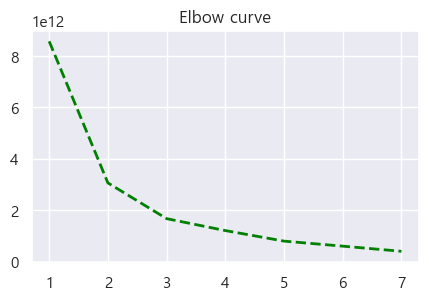

In [12]:




fig = plt.figure(figsize=(5, 3)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

distortions = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    distortions.append(kmeans.inertia_)

ax.plot(range(1, 8), distortions,color='green', linestyle='--', linewidth=2)
plt.title('Elbow curve')

plt.savefig('Elbow curve.png')

# 2에 해당하게 세로선 그리기

Silhouette Coefficient: 0.7045
Davies Bouldin Index: 0.5668


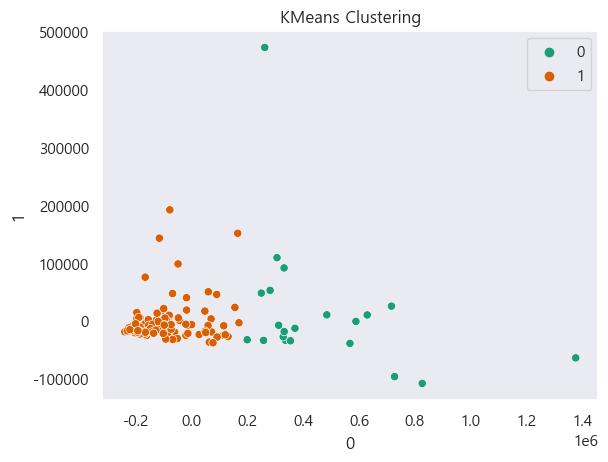

In [13]:
reduced_df = pd.DataFrame(df_pca)

km = KMeans(n_clusters=2, init='k-means++')
cluster = km.fit(reduced_df)
cluster_num = pd.DataFrame(cluster.labels_)

df_km = pd.concat([reduced_df, cluster_num], axis=1)
df_km.columns = [0, 1, "cluster"]

sns.set_palette("Dark2")

sns.scatterplot(data=df_km, x=0, y=1, hue = 'cluster', legend="full", markers= {0: "s", 1: "X"})
# sns.scatterplot(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], hue = 'cluster',  label = 'Centroids')

plt.title("KMeans Clustering")
plt.grid(False)
plt.legend()
plt.savefig('Kmeans Clustering.png', dpi = 300)

print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(df_km.iloc[:,:-1], df_km['cluster'])))
print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(df_km.iloc[:,:-1], df_km['cluster'])))

In [14]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(df_pca)

df_pca['cluster'] = kmeans.labels_

# iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(df_pca, df_pca['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
df_pca['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(df_pca, df_pca['cluster'])
print('Silhouette Analysis Score:{0:.3f}'.format(average_score))

silhouette_samples( ) return 값의 shape (128,)
Silhouette Analysis Score:0.630


# 군집분석 평가(실루엣 계수)

In [15]:
df_pca.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.726890
1    0.459661
2    0.407860
Name: silhouette_coeff, dtype: float64

##### 군집분석 후 파일 저장

In [16]:
df_km = pd.concat([df_dong, df_scaled, cluster_num], axis=1)

df_km.columns = ['법정동', '총 좌석 수', '총 좌석 수_중_노인 및 장애인열람석', '이용자용_컴퓨터 수', '정규직_사서직', '정규직_사서직_정원',
       '결산액_인건비', '결산액_자료구입비', '결산액_운영비', '예산액_인건비', '예산액_자료구입비', '예산액_운영비',
       '회원등록자수_연령별회원등록_성인', '이용자수_도서관방문자수', '정보서비스의뢰및제공_제공', '장애인용_특수자료수_인쇄',
       '도서관총예산', '장애인_예산', '노인_예산', '다문화_예산', '공공도서관', '버스정류장', '지하철역',
       '노인관련시설', '노인보호구역', '지식정보취약계층_예산', '지식정보취약계층_이용자수', '노인인구비율', 'cluster']

#df_km.to_csv('결과(표준화).csv', index=False)

df_km2 = pd.concat([df_dong, df2, cluster_num], axis=1)
#df_km2.to_csv('결과(원본).csv', index=False)

##### 군집별 특성 파악

###### 1) 군집 =0

In [17]:
df_km_0 = df_km[df_km['cluster']==0]
df_km_0

,법정동,총 좌석 수,총 좌석 수_중_노인 및 장애인열람석,이용자용_컴퓨터 수,정규직_사서직,정규직_사서직_정원,결산액_인건비,결산액_자료구입비,결산액_운영비,예산액_인건비,...,다문화_예산,공공도서관,버스정류장,지하철역,노인관련시설,노인보호구역,지식정보취약계층_예산,지식정보취약계층_이용자수,노인인구비율,cluster
5,개포동,-0.157924,-0.199186,0.948950,1.514255,1.472904,1.888797,1.744405,1.815232,2.634686,...,1.303838,-0.438405,-0.878151,-0.223222,-0.426689,-0.541064,3.537383,0.267279,0.148933,0
7,고덕동,-0.092497,-0.174035,3.075611,0.983269,1.117695,1.816837,1.156855,1.749374,-0.151735,...,2.535255,-0.415968,-1.247898,-0.752884,0.203646,-0.105446,6.477304,1.520579,-0.956783,0
8,고척동,-0.067063,-0.120688,1.815083,1.685849,1.644845,0.933466,0.359258,0.604561,0.817561,...,1.448761,-0.343823,0.360504,-0.752884,-0.426689,-0.541064,0.591113,-0.161707,0.539283,0
12,구산동,-0.107984,-0.108095,0.513996,0.277988,0.234130,-0.072317,-0.410528,-0.349556,0.079205,...,-0.534835,-0.253382,0.126330,-0.752884,-0.426689,1.978169,-0.328115,-0.479834,0.689521,0
17,길동,-0.076434,-0.143776,1.042771,1.332732,1.291013,0.267938,-0.044035,0.121985,0.267184,...,0.987505,-0.287901,-0.046218,-0.157974,-0.426689,-0.541064,0.053842,1.551723,0.535996,0
22,답십리동,-0.144534,-0.166689,0.565251,0.278572,0.588765,-0.031192,-0.090707,-0.302904,0.034087,...,-0.326293,-0.294115,0.194118,-0.752884,-0.426689,1.558297,-0.185374,0.286117,0.118031,0
23,당산동,0.034426,0.008044,2.874041,1.687149,1.646148,0.027551,-0.313712,-0.032509,0.033331,...,0.636301,-0.073882,-0.582353,-0.752884,-0.426689,-0.541064,1.583244,2.491581,-2.022768,0
27,도곡동,-0.084457,-0.157419,0.897723,0.453779,0.586425,-0.143053,0.825615,0.096420,-0.132471,...,-0.534835,-0.332776,-0.144818,0.657628,0.192277,0.316175,-0.226282,-0.344495,-0.723459,0
39,목동,-0.117615,-0.179282,0.317895,0.453779,0.410277,1.243955,0.792292,0.891527,1.203764,...,0.436681,-0.307577,-0.582353,0.147157,0.047010,-0.541064,0.389030,0.625704,-0.879067,0
40,묵동,-0.076576,-0.098650,0.031878,0.276314,0.232453,-0.274193,0.561509,0.208470,0.013658,...,1.216526,-0.320695,0.274230,-0.249130,-0.426689,-0.541064,-0.025615,-0.022721,0.379901,0


In [18]:
###### 2) 군집 =1

In [19]:
df_km_1 = df_km[df_km['cluster']==1 ]
df_km_1['법정동']

0      가락동
1      가산동
2      가양동
3      강일동
4      개봉동
      ... 
121    현저동
122    홍은동
123    화곡동
126    휘경동
127    흑석동
Name: 법정동, Length: 107, dtype: object

In [20]:
df_km.drop(labels= '법정동', axis=1, inplace=True)

In [21]:
df_km = df_km.astype({'cluster':'object'})

In [22]:
df_km_mean= df_km.groupby(by = 'cluster').mean()
df_km_mean
# df_km_mean.to_csv('군집별 평균값(정규화).csv') #csv 파일로 저장 

,총 좌석 수,총 좌석 수_중_노인 및 장애인열람석,이용자용_컴퓨터 수,정규직_사서직,정규직_사서직_정원,결산액_인건비,결산액_자료구입비,결산액_운영비,예산액_인건비,예산액_자료구입비,...,노인_예산,다문화_예산,공공도서관,버스정류장,지하철역,노인관련시설,노인보호구역,지식정보취약계층_예산,지식정보취약계층_이용자수,노인인구비율
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.557906,0.614023,1.511635,1.500196,1.507760,0.859844,0.571532,0.975223,0.822397,0.825890,...,0.733028,0.385890,0.300307,-0.109398,-0.396441,-0.313302,-0.170677,0.85967,0.850837,0.119487
1,-0.109496,-0.120509,-0.296676,-0.294431,-0.295915,-0.168754,-0.112170,-0.191399,-0.161405,-0.162091,...,-0.143865,-0.075735,-0.058939,0.021471,0.077806,0.061489,0.033497,-0.16872,-0.166987,-0.023451


In [23]:
df_km_mean2 = pd.read_csv('군집3개 비율 데이터.csv', encoding='cp949')

df_km_2 = df_km_mean2[df_km_mean2['cluster']== 2]
df_km_2

,법정동코드,법정동,총 좌석 수,총 좌석 수_중_노인 및 장애인열람석,이용자용_컴퓨터 수,정규직_사서직,정규직_사서직_정원,결산액_인건비,결산액_자료구입비,결산액_운영비,...,다문화_예산,공공도서관,버스정류장,지하철역,노인관련시설,노인보호구역,지식정보취약계층_예산,지식정보취약계층_이용자수,노인인구비율,cluster
128,11470101,양천구_신정동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000034,4.182510e-07,1.394170e-07,4.182510e-07,0.0,0.0,23.692152,2
129,11380109,은평구_신사동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000037,1.079390e-06,5.396940e-07,5.396940e-07,0.0,0.0,0.000000,2
130,11110154,장사동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000017,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,51.562500,2
131,11110153,돈의동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,3.106640e-05,0.000000e+00,0.000000e+00,0.0,0.0,63.371356,2
132,11290132,보문동3가,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,23.256705,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,11680113,율현동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000013,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,23.653088,2
464,11680111,세곡동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000021,0.000000e+00,0.000000e+00,4.128580e-07,0.0,0.0,23.731139,2
465,11680110,압구정동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000009,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,27.320490,2
466,11680107,강남구_신사동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000024,1.163860e-06,5.819300e-07,1.163860e-06,0.0,0.0,28.670177,2


In [24]:
df_km_2.columns

Index(['법정동코드', '법정동', '총 좌석 수', '총 좌석 수_중_노인 및 장애인열람석', '이용자용_컴퓨터 수',
       '정규직_사서직', '정규직_사서직_정원', '결산액_인건비', '결산액_자료구입비', '결산액_운영비', '예산액_인건비',
       '예산액_자료구입비', '예산액_운영비', '회원등록자수_연령별회원등록_성인', '이용자수_도서관방문자수',
       '정보서비스의뢰및제공_제공', '장애인용_특수자료수_인쇄', '도서관총예산', '장애인_예산', '노인_예산', '다문화_예산',
       '공공도서관', '버스정류장', '지하철역', '노인관련시설', '노인보호구역', '지식정보취약계층_예산',
       '지식정보취약계층_이용자수', '노인인구비율', 'cluster'],
      dtype='object')

In [25]:
df_km_2_d = df_km_2[['법정동', '법정동코드', 'cluster']]

In [26]:
for i in ['법정동', '법정동코드', 'cluster']:
    df_km_2.drop(i, axis=1, inplace=True)


In [27]:
ss = StandardScaler()
df_scaled2 = pd.DataFrame(ss.fit_transform(df_km_2))

In [28]:
df_ss2 = pd.concat([df_km_2_d, df_scaled2], axis=1)
df_ss2.columns = ['법정동', '법정동코드', 'cluster', '총 좌석 수', '총 좌석 수_중_노인 및 장애인열람석', '이용자용_컴퓨터 수',
       '정규직_사서직', '정규직_사서직_정원', '결산액_인건비', '결산액_자료구입비', '결산액_운영비', '예산액_인건비',
       '예산액_자료구입비', '예산액_운영비', '회원등록자수_연령별회원등록_성인', '이용자수_도서관방문자수',
       '정보서비스의뢰및제공_제공', '장애인용_특수자료수_인쇄', '도서관총예산', '장애인_예산', '노인_예산', '다문화_예산',
       '공공도서관', '버스정류장', '지하철역', '노인관련시설', '노인보호구역', '지식정보취약계층_예산',
       '지식정보취약계층_이용자수', '노인인구비율']
df_ss2.columns

Index(['법정동', '법정동코드', 'cluster', '총 좌석 수', '총 좌석 수_중_노인 및 장애인열람석',
       '이용자용_컴퓨터 수', '정규직_사서직', '정규직_사서직_정원', '결산액_인건비', '결산액_자료구입비',
       '결산액_운영비', '예산액_인건비', '예산액_자료구입비', '예산액_운영비', '회원등록자수_연령별회원등록_성인',
       '이용자수_도서관방문자수', '정보서비스의뢰및제공_제공', '장애인용_특수자료수_인쇄', '도서관총예산', '장애인_예산',
       '노인_예산', '다문화_예산', '공공도서관', '버스정류장', '지하철역', '노인관련시설', '노인보호구역',
       '지식정보취약계층_예산', '지식정보취약계층_이용자수', '노인인구비율'],
      dtype='object')

In [29]:
df_all = pd.concat([df_km,df_ss2], axis=0)
df_all

df_all_mean = df_all.groupby(by = 'cluster').mean()
df_all_mean.to_csv('군집별 평균값(정규화)도서관없는동포함.csv')

In [30]:
df_km_mean = df_km_mean2.groupby(by = 'cluster').mean()
df_km_mean2
df_km_mean2.to_csv('군집별 평균값(정규화)도서관없는동포함.csv')

In [31]:
df_km_0.loc['평균'] = df_km_0.mean(axis=0) 
#df_km_0.to_csv('군집0(평균).csv')

df_km_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 5 to 평균
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   법정동                   21 non-null     object 
 1   총 좌석 수                22 non-null     float64
 2   총 좌석 수_중_노인 및 장애인열람석  22 non-null     float64
 3   이용자용_컴퓨터 수            22 non-null     float64
 4   정규직_사서직               22 non-null     float64
 5   정규직_사서직_정원            22 non-null     float64
 6   결산액_인건비               22 non-null     float64
 7   결산액_자료구입비             22 non-null     float64
 8   결산액_운영비               22 non-null     float64
 9   예산액_인건비               22 non-null     float64
 10  예산액_자료구입비             22 non-null     float64
 11  예산액_운영비               22 non-null     float64
 12  회원등록자수_연령별회원등록_성인     22 non-null     float64
 13  이용자수_도서관방문자수          22 non-null     float64
 14  정보서비스의뢰및제공_제공         22 non-null     float64
 15  장애인용_특수자료수_인쇄         22 non-n

In [32]:
df_km_1.loc['평균'] = df_km_0.mean(axis=0) 
#df_km_1.to_csv('군집1(평균).csv')
df_km_1['법정동']

0      가락동
1      가산동
2      가양동
3      강일동
4      개봉동
      ... 
122    홍은동
123    화곡동
126    휘경동
127    흑석동
평균     NaN
Name: 법정동, Length: 108, dtype: object

In [33]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

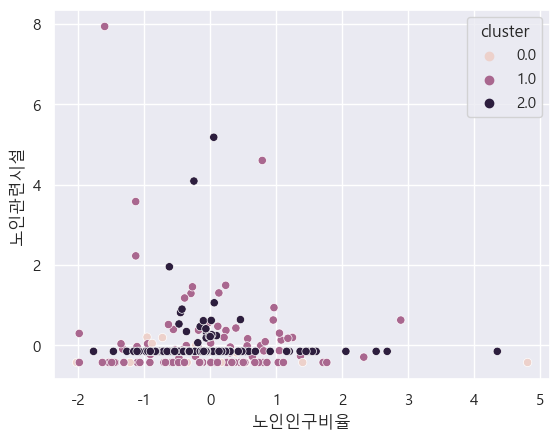

In [36]:
sns.scatterplot(data = df_all, x='노인인구비율', y='노인관련시설', hue='cluster')
plt.savefig('산점도로 표현한 군집별 특성.png',  bbox_inches = 'tight')